In [24]:
import numpy as np

House_Vert_3d = [[0,0,0],
                 [4,0,0],
                 [4,4,0],
                 [0,4,0],
                 [0,0,2],
                 [4,0,2],
                 [4,4,2],
                 [0,4,2],
                 [2,1,3],
                 [2,3,3]]
House_Edge = [(1, 2), (1, 4), (3, 2), (3, 4), (1, 5), (2, 6), (4, 8), (3, 7), \
                 (5, 6), (5, 8), (7, 8), (7, 6), (9, 10), (5, 9), (6, 9), (7, 10), (8, 10)]

M_ext = np.asarray([[-0.707, -0.707, 0, 3], [0.707, -0.707, 0, 0.5], [0, 0, 1, 3]])
M_int = np.asarray([[100, 0, 200], [-0, 100, 200], [0, 0, 1]])

def takePicture(mExt):
    House_Vert_3d_2 = np.concatenate((House_Vert_3d, np.asarray([np.ones(10)]).T), axis=1)
    House_Vert_2d_homo = M_int.dot(mExt).dot(House_Vert_3d_2.T)
    House_Vert_2d = []
    for vert in House_Vert_2d_homo.T:
        House_Vert_2d.append([vert[0]/vert[2], vert[1]/vert[2]])
    return House_Vert_2d



House_Vert_2d = takePicture(M_ext)

In [2]:
print(House_Vert_2d)

[[300.0, 216.66666666666666], [205.73333333333335, 310.93333333333334], [111.46666666666668, 216.66666666666666], [205.73333333333335, 122.39999999999999], [260.0, 210.0], [203.44, 266.56], [146.88000000000002, 210.0], [203.44, 153.44], [214.65000000000001, 220.11666666666665], [191.08333333333334, 196.54999999999998]]


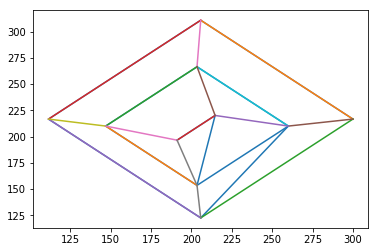

In [25]:
#Draw 2d house
import matplotlib.pyplot as plt

    
def drawmyobject(house2d, ax2d):
    for edge in House_Edge:
        ax2d.plot([house2d[edge[0]-1][0],house2d[edge[1]-1][0]],\
                  [house2d[edge[0]-1][1], house2d[edge[1]-1][1]])
        
fig, ax = plt.subplots()
data = np.asarray(House_Vert_2d).T
ax.plot(data[0], data[1])
drawmyobject(House_Vert_2d, ax)
plt.show()

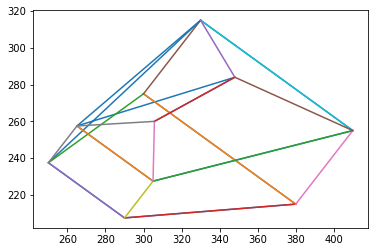

In [26]:
#Take another picture

M_ext_2 = np.asarray([[0.8, 0, 0.6, 4], [-0.6, 0, 0.8, 3], [0, 1, 0, 4]])
House_Vert_2d_2 = takePicture(M_ext_2)

fig2, ax = plt.subplots()
data = np.asarray(House_Vert_2d_2).T
ax.plot(data[0], data[1])
drawmyobject(House_Vert_2d_2, ax)
plt.show()
    

In [27]:
R_w_1 = M_ext[:, :-1]
r_w_2 = np.asarray([[0.866, -0.5, 0], [0.5, 0.866, 0], [0, 0, 1]])
#objective: calc R_2_1
r_w_1 = np.asarray([[0.707, 0.707, 0], [-0.707, 0.707, 0], [0, 0, 1]])

print(r_w_1.dot(r_w_2.T))
print((r_w_2.T).dot(r_w_1))

[[ 0.258762  0.965762  0.      ]
 [-0.965762  0.258762  0.      ]
 [ 0.        0.        1.      ]]
[[ 0.258762  0.965762  0.      ]
 [-0.965762  0.258762  0.      ]
 [ 0.        0.        1.      ]]


In [33]:
# M_ext = np.asarray([[-0.707, 0.707, 0, 3], [0.707, -0.707, 0, 0.5], [0, 0, 1, 3]])
# M_ext_2 = np.asarray([[0.8, 0, 0.6, 4], [-0.6, 0, 0.8, 3], [0, 1, 0, 4]])
# M_int = np.asarray([[100, 0, 200], [-0, 100, 200], [0, 0, 1]])

#Assume focal length and other internal params do NOT change
# s_x = s_y =1, f=100, o_x = o_y = 200
def Recon3d_from2x2d(house2d_1, house2d_2, mExt_1, mExt_2):
    house3d = []
    R_w_1 = mExt_1[:, :-1]; R_w_2 = mExt_2[:, :-1]
    #R_2_1 = (R_w_1).dot(R_w_2.T)
    R_2_1 = (R_w_1).dot(R_w_2.T)
    #print((R_2_1, R_w_1, R_w_2))
    #t_2_1 = -(R_w_2.T).dot(mExt_2[:, -1]) - mExt_1[:, -1]
    t_2_1 = mExt_1[:, -1] -(R_w_2.T).dot(mExt_2[:, 1])
    print(t_2_1)
    for i in range(0, len(House_Vert_2d)):
        #Get 2D camera coordinates from pixel coordinates:
        ptim_1 = house2d_1[i]; Pt2d_1 = np.asarray([(ptim_1[0]-200)*(-1), (ptim_1[1]-200)*(-1), 100])
        ptim_2 = house2d_2[i]; Pt2d_2 = np.asarray([(ptim_2[0]-200)*(-1), (ptim_2[1]-200)*(-1), 100])
        q = np.cross(Pt2d_1, R_2_1.dot(Pt2d_2))
        mat = np.asarray([Pt2d_1, -R_2_1.dot(Pt2d_2), q]).T
        # t_2_1 = t_2_w - t_w_1
        dist = np.linalg.inv(mat).dot(t_2_1)
        #print((Pt2d_1, dist))
        Pt3d = dist[0]*Pt2d_1 + dist[2]/2*q
        house3d.append(Pt3d)
    return house3d

House_recon = Recon3d_from2x2d(House_Vert_2d, House_Vert_2d_2, M_ext, M_ext_2)
print(House_recon)

[ 3.  -0.5  3. ]
[array([ 1.31791495, -1.10077671,  0.13110213]), array([ 1.54094886, -1.80971659,  1.92215855]), array([ 2.90614435, -0.50601573,  3.09067723]), array([ 0.72345293, -1.58248742,  0.42152361]), array([ 1.33391528, -1.04955658, -0.39140233]), array([ 1.51378203, -1.27035239,  2.19559885]), array([ 2.53011457, -0.28402283,  3.49360027]), array([ 0.83761349, -1.21573385,  0.48913295]), array([ 1.30044543, -0.81295469,  1.8395203 ]), array([ 1.62247055, -0.24366471,  3.00722657])]


In [42]:
#Problem 2
print('problem 2')
import numpy as np
theta_0 = float(input('1st angle(z0)?'))/180*np.pi
theta_1 = float(input('2nd angle(x1)?'))/180*np.pi
theta_2 = float(input('3rd angle(x2)?'))/180*np.pi
theta_3 = float(input('4th angle(z3)?'))/180*np.pi
length_1, length_2, length_3 = (10, 20, 15)
T_1_0 = np.asarray([[np.cos(theta_0), -np.sin(theta_0), 0, length_1*np.cos(theta_0)], \
                    [np.sin(theta_0), np.cos(theta_0), 0, length_1*np.sin(theta_0)], \
                   [0, 0, 1, 0]])
#Note for t_2_1: the initial position is along z1 axis, theta+90
T_2_1 = np.asarray([[1, 0, 0, 0], \
                   [0, np.cos(theta_1), -np.sin(theta_1), -length_2*np.sin(theta_1)], \
                   [0, np.sin(theta_1), np.cos(theta_1), length_2*np.cos(theta_1)], \
                   [0, 0, 0, 1]])
#Note for t_3_2: same with that t_2_1
T_3_2 = np.asarray([[1, 0, 0, 0], \
                   [0, np.cos(theta_2), -np.sin(theta_2), -length_3*np.sin(theta_2)], \
                   [0, np.sin(theta_2), np.cos(theta_2), length_3*np.cos(theta_2)], \
                   [0, 0, 0, 1]])

T_3_0 = T_1_0.dot(T_2_1).dot(T_3_2)

print("T_1_0:\n", T_1_0)
print("T_2_1:\n", T_2_1)
print("T_3_2:\n", T_3_2)
print("T_3_0:\n", T_3_0)
print("Position of wrist:\n", T_3_0[:, -1])

problem 2
1st angle(z0)?0
2nd angle(x1)?0
3rd angle(x2)?0
4th angle(z3)?0
T_1_0:
 [[  1.  -0.   0.  10.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]]
T_2_1:
 [[  1.   0.   0.   0.]
 [  0.   1.  -0.  -0.]
 [  0.   0.   1.  20.]
 [  0.   0.   0.   1.]]
T_3_2:
 [[  1.   0.   0.   0.]
 [  0.   1.  -0.  -0.]
 [  0.   0.   1.  15.]
 [  0.   0.   0.   1.]]
T_3_0:
 [[  1.   0.   0.  10.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.  35.]]
Position of wrist:
 [ 10.   0.  35.]


In [68]:
import numpy as np
import cv2 as cv
import glob

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
path = 'O:\\Photographs\\20181019'
images=glob.glob(path + '\\*.JPG')

objpoints = []
imgpoints = []

fname='O:\\Photographs\\20181019\\P1060200.JPG'
img = cv.imread(fname)
cv.imshow('img', img)
cv.waitKey(0)
cv.destroyAllWindows()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print('1')
ret, corners= cv.findChessboardCorners(gray, (3,7),  flags = cv.CALIB_CB_ADAPTIVE_THRESH) #| cv.CALIB_CB_FAST_CHECK)
print(corners)
if ret==False:
    print(fname)
else:
    objpoints.append(objp)
    imgpoints.append(corners)

    cv.drawChessboardCorners(img, (3,7), corners, ret)
    cv.imshow('img', img)
    cv.waitKey(500)
    
cv.destroyAllWindows()
"""for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    print('1')
    ret = cv.findChessboardCorners(gray, (7,7), corners, None)
    
    if ret==False:
        print(fname)
    else:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv.drawChessboardCorners(img, (7,7), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
        
cv.destroyAllWindows()"""


1
None
O:\Photographs\20181019\P1060200.JPG


"for fname in images:\n    img = cv.imread(fname)\n    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)\n    print('1')\n    ret = cv.findChessboardCorners(gray, (7,7), corners, None)\n    \n    if ret==False:\n        print(fname)\n    else:\n        objpoints.append(objp)\n        imgpoints.append(corners)\n        \n        cv.drawChessboardCorners(img, (7,7), corners2, ret)\n        cv.imshow('img', img)\n        cv.waitKey(500)\n        \ncv.destroyAllWindows()"

problem 1
[ 3.  -0.5  3. ]


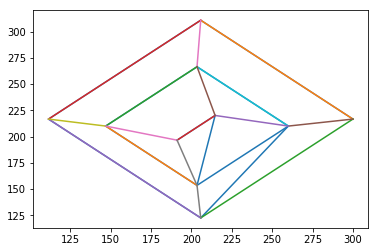

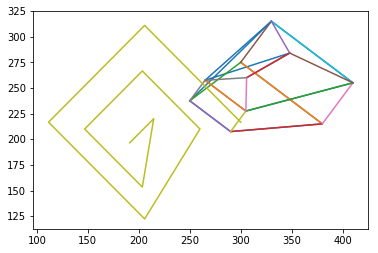

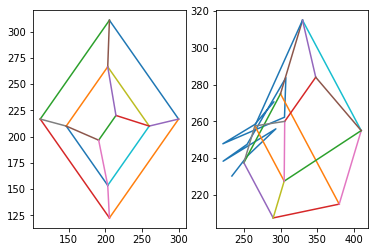

Problem 2
1st angle(z0)?34


KeyboardInterrupt: 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

print('problem 1')
House_Vert_3d = [[0,0,0],[4,0,0],[4,4,0],[0,4,0],\
                 [0,0,2],[4,0,2],[4,4,2],[0,4,2],\
                 [2,1,3],[2,3,3]]
House_Edge = [(1, 2), (1, 4), (3, 2), (3, 4), (1, 5), (2, 6), (4, 8), (3, 7), \
                 (5, 6), (5, 8), (7, 8), (7, 6), (9, 10), (5, 9), (6, 9), (7, 10), (8, 10)]

M_ext = np.asarray([[-0.707, -0.707, 0, 3], [0.707, -0.707, 0, 0.5], [0, 0, 1, 3]])
M_int = np.asarray([[100, 0, 200], [-0, 100, 200], [0, 0, 1]])

def takePicture(mExt, house3d):
    House_Vert_3d_2 = np.concatenate((house3d, \
                                      np.asarray([np.ones(10)]).T), axis=1)
    House_Vert_2d_homo = M_int.dot(mExt).dot(House_Vert_3d_2.T)
    House_Vert_2d = []
    for vert in House_Vert_2d_homo.T:
        House_Vert_2d.append([vert[0]/vert[2], vert[1]/vert[2]])
    return House_Vert_2d

House_Vert_2d = takePicture(M_ext, House_Vert_3d)

def drawmyobject(house2d, ax2d):
    for edge in House_Edge:
        ax2d.plot([house2d[edge[0]-1][0],house2d[edge[1]-1][0]],\
                  [house2d[edge[0]-1][1], house2d[edge[1]-1][1]])

"""def press(key):
    if key == 'n':
        plt.close(event.canvas.figure)"""
        
"""plt.figure()
data = np.asarray(House_Vert_2d).T
plt.plot(data[0], data[1])      
"""
fig, ax = plt.subplots()
data = np.asarray(House_Vert_2d).T
ax.plot(data[0], data[1])
drawmyobject(House_Vert_2d, ax)
#fig.canvas.manager.show()
#fig.canvas.mpl_connect('key_press_event', press)


M_ext_2 = np.asarray([[0.8, 0, 0.6, 4], [-0.6, 0, 0.8, 3], [0, 1, 0, 4]])
House_Vert_2d_2 = takePicture(M_ext_2, House_Vert_3d)

fig, ax = plt.subplots()
data = np.asarray(House_Vert_2d_2).T
ax.plot(data[0], data[1])
drawmyobject(House_Vert_2d_2, ax)
#fig.canvas.mpl_connect('key_press_event', press)


def Recon3d_from2x2d(house2d_1, house2d_2, mExt_1, mExt_2):
    house3d = []
    R_w_1 = mExt_1[:, :-1]; R_w_2 = mExt_2[:, :-1]
    #R_2_1 = (R_w_1).dot(R_w_2.T)
    R_2_1 = (R_w_1).dot(R_w_2.T)
    #print((R_2_1, R_w_1, R_w_2))
    #t_2_1 = -(R_w_2.T).dot(mExt_2[:, -1]) - mExt_1[:, -1]
    t_2_1 = mExt_1[:, -1] -(R_w_2.T).dot(mExt_2[:, 1])
    print(t_2_1)
    for i in range(0, len(House_Vert_2d)):
        #Get 2D camera coordinates from pixel coordinates:
        ptim_1 = house2d_1[i]; Pt2d_1 = np.asarray([(ptim_1[0]-200)*(-1), (ptim_1[1]-200)*(-1), 100])
        ptim_2 = house2d_2[i]; Pt2d_2 = np.asarray([(ptim_2[0]-200)*(-1), (ptim_2[1]-200)*(-1), 100])
        q = np.cross(Pt2d_1, R_2_1.dot(Pt2d_2))
        mat = np.asarray([Pt2d_1, -R_2_1.dot(Pt2d_2), q]).T
        # t_2_1 = t_2_w - t_w_1
        dist = np.linalg.inv(mat).dot(t_2_1)
        #print((Pt2d_1, dist))
        Pt3d = dist[0]*Pt2d_1 + dist[2]/2*q
        house3d.append(Pt3d)
    return house3d

House_recon = Recon3d_from2x2d(House_Vert_2d, House_Vert_2d_2, M_ext, M_ext_2)
House_recon_2d = takePicture(M_ext, House_recon)
fig = plt.figure()
ax1 = fig.add_subplot(121)
data = np.asarray(House_Vert_2d).T
ax.plot(data[0], data[1])
drawmyobject(House_Vert_2d, ax1)

ax2=fig.add_subplot(122)
data = np.asarray(House_recon_2d).T
ax2.plot(data[0], data[1])
drawmyobject(House_Vert_2d_2, ax2)
#fig.canvas.mpl_connect('key_press_event', press)
plt.show()


print('Problem 2')
import numpy as np
theta_0 = float(input('1st angle(z0)?'))/180*np.pi
theta_1 = float(input('2nd angle(x1)?'))/180*np.pi
theta_2 = float(input('3rd angle(x2)?'))/180*np.pi
theta_3 = float(input('4th angle(z3)?'))/180*np.pi
length_1, length_2, length_3 = (10, 20, 15)
T_1_0 = np.asarray([[np.cos(theta_0), -np.sin(theta_0), 0, length_1*np.cos(theta_0)], \
                    [np.sin(theta_0), np.cos(theta_0), 0, length_1*np.sin(theta_0)], \
                   [0, 0, 1, 0]])
#Note for t_2_1: the initial position is along z1 axis, theta+90
T_2_1 = np.asarray([[1, 0, 0, 0], \
                   [0, np.cos(theta_1), -np.sin(theta_1), -length_2*np.sin(theta_1)], \
                   [0, np.sin(theta_1), np.cos(theta_1), length_2*np.cos(theta_1)], \
                   [0, 0, 0, 1]])
#Note for t_3_2: same with that t_2_1
T_3_2 = np.asarray([[1, 0, 0, 0], \
                   [0, np.cos(theta_2), -np.sin(theta_2), -length_3*np.sin(theta_2)], \
                   [0, np.sin(theta_2), np.cos(theta_2), length_3*np.cos(theta_2)], \
                   [0, 0, 0, 1]])

T_3_0 = T_1_0.dot(T_2_1).dot(T_3_2)

print("T_1_0:\n", T_1_0)
print("T_2_1:\n", T_2_1)
print("T_3_2:\n", T_3_2)
print("T_3_0:\n", T_3_0)
print("Position of wrist:\n", T_3_0[:, -1])

In [47]:
print(images)

['O:\\Photographs\\20181018\\P1060166.JPG', 'O:\\Photographs\\20181018\\P1060167.JPG', 'O:\\Photographs\\20181018\\P1060168.JPG', 'O:\\Photographs\\20181018\\P1060169.JPG', 'O:\\Photographs\\20181018\\P1060170.JPG', 'O:\\Photographs\\20181018\\P1060171.JPG', 'O:\\Photographs\\20181018\\P1060172.JPG', 'O:\\Photographs\\20181018\\P1060173.JPG', 'O:\\Photographs\\20181018\\P1060174.JPG', 'O:\\Photographs\\20181018\\P1060175.JPG', 'O:\\Photographs\\20181018\\P1060176.JPG', 'O:\\Photographs\\20181018\\P1060177.JPG', 'O:\\Photographs\\20181018\\P1060178.JPG', 'O:\\Photographs\\20181018\\P1060179.JPG', 'O:\\Photographs\\20181018\\P1060180.JPG', 'O:\\Photographs\\20181018\\P1060181.JPG', 'O:\\Photographs\\20181018\\P1060182.JPG', 'O:\\Photographs\\20181018\\P1060183.JPG', 'O:\\Photographs\\20181018\\P1060184.JPG', 'O:\\Photographs\\20181018\\P1060185.JPG', 'O:\\Photographs\\20181018\\P1060186.JPG', 'O:\\Photographs\\20181018\\P1060187.JPG']


In [58]:
ret

(False, None)